# Rendu Projet BigData Manel NASRI & Mariama MANE MASTER2 ACSI

# Description du projet

L'objectif de ce projet, en utilisant ce dataset, est de savoir quelles sont les zones de New York dans lesquelles il est intéressant pour un chauffeur de taxi de se rendre afin d'obtenir le plus gros pourboire.

le projet se déroule sur trois étape:

- Analyse exploratoire des données
- Nettoyage des données
- Fouille des données en utilisant un algorithme de clustering Kmeans

# Etape I : Analyse exploratoire des données¶

Dans ce script, nous réalisons une analyse exploratoire des données de deux fichiers Fares et Rides afin d’analyser 
les jeux de données, afficher les contenus des fichiers, les types des différentes données et aussi afin de pouvoir 
faire un premier diagnostic sur les données

### Nous commençons par importer les librairies necessaires

In [1]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml import Pipeline, PipelineModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from numpy import *
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_cs)

In [3]:
spark = (SparkSession.builder
.master('local[2]')
.appName('ProjetBigdata')
.getOrCreate())

# 1. Import des données
### Import fichier "Fares"

In [4]:
###################################################
#############Fares#################################
###################################################

In [5]:
dataFares = spark.read.options(header='True', inferSchema='True').format("csv").load("nycTaxiFares.csv")
#dataFares = spark.read.options(header='True', inferSchema='True').format("csv").load("data1.csv")
# visualier le dataframe
dataFares.show()

22/03/26 09:27:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 1, 2013000001, 2013000001, 2013-01-01 00:00:00, CSH, 0, 0, 21.5
 Schema: 1, 20130000011, 20130000012, 2013-01-01 00:00:00, CSH, 05, 06, 21.5
Expected: 20130000011 but found: 2013000001
CSV file: file:///home/jovyan/nycTaxiFares.csv


+---+-----------+-----------+-------------------+---+----+---+-----+
|  1|20130000011|20130000012|2013-01-01 00:00:00|CSH|  05| 06| 21.5|
+---+-----------+-----------+-------------------+---+----+---+-----+
|  2| 2013000002| 2013000002|2013-01-01 00:00:00|CSH| 0.0|0.0|  7.0|
|  3| 2013000003| 2013000003|2013-01-01 00:00:00|CRD| 2.2|0.0| 13.7|
|  4| 2013000004| 2013000004|2013-01-01 00:00:00|CRD| 1.7|0.0| 10.7|
|  5| 2013000005| 2013000005|2013-01-01 00:00:00|CRD|4.65|0.0|20.15|
|  6| 2013000006| 2013000006|2013-01-01 00:00:00|CSH| 0.0|4.8| 34.3|
|  7| 2013000007| 2013000007|2013-01-01 00:00:00|CRD| 1.9|0.0| 11.9|
|  8| 2013000008| 2013000008|2013-01-01 00:00:00|CSH| 0.0|0.0|  6.0|
|  9| 2013000009| 2013000009|2013-01-01 00:00:00|CRD| 1.0|0.0|  6.0|
| 10| 2013000010| 2013000010|2013-01-01 00:00:00|CSH| 0.0|0.0| 15.5|
| 11| 2013000011| 2013000011|2013-01-01 00:00:00|CRD| 4.7|0.0| 28.7|
| 12| 2013000012| 2013000012|2013-01-01 00:00:00|CRD| 4.0|0.0| 30.5|
| 13| 2013000013| 2013000013|2013-

In [6]:
dataFares.printSchema()

root
 |-- 1: integer (nullable = true)
 |-- 20130000011: integer (nullable = true)
 |-- 20130000012: integer (nullable = true)
 |-- 2013-01-01 00:00:00: string (nullable = true)
 |-- CSH: string (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 21.5: double (nullable = true)



### Import fichier "Rides"

In [7]:
###################################################
#############Rides#################################
###################################################

In [8]:
dataRides = spark.read.options(header='True', inferSchema='True').format("csv").load("nycTaxiRides.csv")
#dataRides = spark.read.options(header='True', inferSchema='True').format("csv").load("data2.csv")
dataRides.show()

+---+-----+-------------------+-------------------+----------+---------+----------+---------+---+-----------+------------+
| 60|START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.866135|40.771091|-73.961334|40.764912| 68|20130000069|201300000610|
+---+-----+-------------------+-------------------+----------+---------+----------+---------+---+-----------+------------+
| 11|START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.870834|40.773769|-73.792358|40.771759|  1| 2013000011|  2013000011|
| 55|START|2013-01-01 00:00:00|1970-01-01 00:00:00| -73.87117|40.773914|-73.805054| 40.68121|  1| 2013000055|  2013000055|
| 31|START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.929344|40.807728|-73.979935|40.740757|  2| 2013000031|  2013000031|
| 34|START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.934555|40.750957|-73.916328|40.762241|  5| 2013000034|  2013000034|
| 43|START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.946136|40.781349|-73.944977|40.790836|  1| 2013000043|  2013000043|
| 54|START|2013-

22/03/26 09:28:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 6, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006, 2013000006
 Schema: 60, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 20130000069, 201300000610
Expected: 60 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


In [9]:
dataRides.printSchema()

root
 |-- 60: integer (nullable = true)
 |-- START: string (nullable = true)
 |-- 2013-01-01 00:00:00: string (nullable = true)
 |-- 1970-01-01 00:00:00: string (nullable = true)
 |-- -73.866135: double (nullable = true)
 |-- 40.771091: double (nullable = true)
 |-- -73.961334: double (nullable = true)
 |-- 40.764912: double (nullable = true)
 |-- 68: integer (nullable = true)
 |-- 20130000069: integer (nullable = true)
 |-- 201300000610: integer (nullable = true)



Après avoir téléchargé les fichiers, nous avons constaté que les deux fichiers ne contiennet pas des entêtes,
la raison pour laquelle nous allons ajouter les entêtes pour les deux fichiers

### Ajout des entêtes pour les deux fichiers

In [10]:
###################################################
#############Fares#################################
###################################################

In [11]:
dtfares=dataFares.toDF('rideId', 'taxiId', 'driverId', 'startTime', 'paymentType', 'tip', 'tolls', 'totalFare')  
dtfares.show()

+------+----------+----------+-------------------+-----------+----+-----+---------+
|rideId|    taxiId|  driverId|          startTime|paymentType| tip|tolls|totalFare|
+------+----------+----------+-------------------+-----------+----+-----+---------+
|     2|2013000002|2013000002|2013-01-01 00:00:00|        CSH| 0.0|  0.0|      7.0|
|     3|2013000003|2013000003|2013-01-01 00:00:00|        CRD| 2.2|  0.0|     13.7|
|     4|2013000004|2013000004|2013-01-01 00:00:00|        CRD| 1.7|  0.0|     10.7|
|     5|2013000005|2013000005|2013-01-01 00:00:00|        CRD|4.65|  0.0|    20.15|
|     6|2013000006|2013000006|2013-01-01 00:00:00|        CSH| 0.0|  4.8|     34.3|
|     7|2013000007|2013000007|2013-01-01 00:00:00|        CRD| 1.9|  0.0|     11.9|
|     8|2013000008|2013000008|2013-01-01 00:00:00|        CSH| 0.0|  0.0|      6.0|
|     9|2013000009|2013000009|2013-01-01 00:00:00|        CRD| 1.0|  0.0|      6.0|
|    10|2013000010|2013000010|2013-01-01 00:00:00|        CSH| 0.0|  0.0|   

22/03/26 09:28:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 1, 2013000001, 2013000001, 2013-01-01 00:00:00, CSH, 0, 0, 21.5
 Schema: 1, 20130000011, 20130000012, 2013-01-01 00:00:00, CSH, 05, 06, 21.5
Expected: 20130000011 but found: 2013000001
CSV file: file:///home/jovyan/nycTaxiFares.csv


## Afficher le schéma de données du fichier Fares après avoir ajouté les entêtes:

In [12]:
dtfares.printSchema()

root
 |-- rideId: integer (nullable = true)
 |-- taxiId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- startTime: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- tip: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- totalFare: double (nullable = true)



Après avoir affiché le schéma de données du fichier Fares: nous avons eu connaissances des colonnes ainsi que leurs types 

In [13]:
###################################################
#############Rides#################################
###################################################

In [14]:
dtRides= dataRides .toDF('rideId', 'status', 'endTime', 'startTime', 'startLon', 'startLat', 'endLon', 'endLat', 'passengerCount', 'taxiId', 'driverId')  
dtRides.show()

+------+------+-------------------+-------------------+----------+---------+----------+---------+--------------+----------+----------+
|rideId|status|            endTime|          startTime|  startLon| startLat|    endLon|   endLat|passengerCount|    taxiId|  driverId|
+------+------+-------------------+-------------------+----------+---------+----------+---------+--------------+----------+----------+
|    11| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.870834|40.773769|-73.792358|40.771759|             1|2013000011|2013000011|
|    55| START|2013-01-01 00:00:00|1970-01-01 00:00:00| -73.87117|40.773914|-73.805054| 40.68121|             1|2013000055|2013000055|
|    31| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.929344|40.807728|-73.979935|40.740757|             2|2013000031|2013000031|
|    34| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.934555|40.750957|-73.916328|40.762241|             5|2013000034|2013000034|
|    43| START|2013-01-01 00:00:00|1970-01-01 00:00:00|

22/03/26 09:28:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 6, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006, 2013000006
 Schema: 60, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 20130000069, 201300000610
Expected: 60 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


## Afficher le schéma de données du fichier Rides après avoir ajouté les entêtes:

In [15]:
dtRides.printSchema()

root
 |-- rideId: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- startTime: string (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- taxiId: integer (nullable = true)
 |-- driverId: integer (nullable = true)



Après avoir affiché le schéma de données du fichier Rides: nous avons eu connaissances des colonnes ainsi que leurs types 

# 2. Visualisation de la table

### Nous allons afficher les données pour les analyses: type, taille, nombre de colonnes

In [16]:
###################################################
#############Fares#################################
###################################################

In [17]:
dtfares.cache()
dtfares.createOrReplaceTempView("dfTable")
dtfares.show()

22/03/26 09:28:54 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 1, 2013000001, 2013000001, 2013-01-01 00:00:00, CSH, 0, 0, 21.5
 Schema: 1, 20130000011, 20130000012, 2013-01-01 00:00:00, CSH, 05, 06, 21.5
Expected: 20130000011 but found: 2013000001
CSV file: file:///home/jovyan/nycTaxiFares.csv


+------+----------+----------+-------------------+-----------+----+-----+---------+
|rideId|    taxiId|  driverId|          startTime|paymentType| tip|tolls|totalFare|
+------+----------+----------+-------------------+-----------+----+-----+---------+
|     2|2013000002|2013000002|2013-01-01 00:00:00|        CSH| 0.0|  0.0|      7.0|
|     3|2013000003|2013000003|2013-01-01 00:00:00|        CRD| 2.2|  0.0|     13.7|
|     4|2013000004|2013000004|2013-01-01 00:00:00|        CRD| 1.7|  0.0|     10.7|
|     5|2013000005|2013000005|2013-01-01 00:00:00|        CRD|4.65|  0.0|    20.15|
|     6|2013000006|2013000006|2013-01-01 00:00:00|        CSH| 0.0|  4.8|     34.3|
|     7|2013000007|2013000007|2013-01-01 00:00:00|        CRD| 1.9|  0.0|     11.9|
|     8|2013000008|2013000008|2013-01-01 00:00:00|        CSH| 0.0|  0.0|      6.0|
|     9|2013000009|2013000009|2013-01-01 00:00:00|        CRD| 1.0|  0.0|      6.0|
|    10|2013000010|2013000010|2013-01-01 00:00:00|        CSH| 0.0|  0.0|   

### - Afficher la taille du fichier Fares:

In [18]:
dataFares.count()

1499998

Nous constatons que le fichier Fares est de taille 1499998 lignes de données

### - Afficher les noms des colonnes du fichier Fares

In [19]:
dtfares.columns

['rideId',
 'taxiId',
 'driverId',
 'startTime',
 'paymentType',
 'tip',
 'tolls',
 'totalFare']

Nous avons affiché les noms des colonnes du fichier Fares

### - Afficher le nombre de colonnes du fichier Fares

In [20]:
len(dtfares.columns)

8

Nous constatons que le fichier Fares contient 8 colonnes

### - Afficher les types de données du fichier Fares

In [21]:
dtfares.dtypes

[('rideId', 'int'),
 ('taxiId', 'int'),
 ('driverId', 'int'),
 ('startTime', 'string'),
 ('paymentType', 'string'),
 ('tip', 'double'),
 ('tolls', 'double'),
 ('totalFare', 'double')]

Nous constatons que le fichier de données Fares contient 8 colonnes de type:
- rideId:entier
- taxiId:entier
- driverId::entier
- startTime:string
- paymentType:string
- tip:double
- tolls:double
- totalFare:double

In [22]:
###################################################
#############Rides#################################
###################################################

In [23]:
dtRides.createOrReplaceTempView("dtRides")
dtRides.show()

+------+------+-------------------+-------------------+----------+---------+----------+---------+--------------+----------+----------+
|rideId|status|            endTime|          startTime|  startLon| startLat|    endLon|   endLat|passengerCount|    taxiId|  driverId|
+------+------+-------------------+-------------------+----------+---------+----------+---------+--------------+----------+----------+
|    11| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.870834|40.773769|-73.792358|40.771759|             1|2013000011|2013000011|
|    55| START|2013-01-01 00:00:00|1970-01-01 00:00:00| -73.87117|40.773914|-73.805054| 40.68121|             1|2013000055|2013000055|
|    31| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.929344|40.807728|-73.979935|40.740757|             2|2013000031|2013000031|
|    34| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.934555|40.750957|-73.916328|40.762241|             5|2013000034|2013000034|
|    43| START|2013-01-01 00:00:00|1970-01-01 00:00:00|

22/03/26 09:29:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 6, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006, 2013000006
 Schema: 60, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 20130000069, 201300000610
Expected: 60 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


### - Afficher la taille du fichier Rides:

In [24]:
dtRides.count()

2999997

Nous constatons que le fichier Rides est de taille 2999997 lignes de données

### - Afficher les noms des colonnes du fichier Rides:

In [25]:
dtRides.columns

['rideId',
 'status',
 'endTime',
 'startTime',
 'startLon',
 'startLat',
 'endLon',
 'endLat',
 'passengerCount',
 'taxiId',
 'driverId']

### - Afficher le nombre de colonnes du fichier Rides

In [26]:
len(dtRides.columns)

11

Nous constatons que le fichier Rides contient 11 colonnes

### - Afficher les types des colonnes du fichier Rides

In [27]:
dtRides.dtypes

[('rideId', 'int'),
 ('status', 'string'),
 ('endTime', 'string'),
 ('startTime', 'string'),
 ('startLon', 'double'),
 ('startLat', 'double'),
 ('endLon', 'double'),
 ('endLat', 'double'),
 ('passengerCount', 'int'),
 ('taxiId', 'int'),
 ('driverId', 'int')]

Nous constatons que le fichier de données Rides contient 11 colonnes de type:rideId:entier
- status:string
- endTime:string
- startTime:string
- startLon:double
- startLat:double
- endLon:double
- endLat:double
- passengerCount:entier
- taxiId:entier
- driverId:entier

# 3.Analyse exploratoire

In [28]:
###################################################
#############Fares#################################
###################################################

### - Afficher les valeurs distinctes des colonnes du fichier Fares

In [29]:
dtfares.distinct().show()

+------+----------+----------+-------------------+-----------+----+-----+---------+
|rideId|    taxiId|  driverId|          startTime|paymentType| tip|tolls|totalFare|
+------+----------+----------+-------------------+-----------+----+-----+---------+
|   372|2013000372|2013000372|2013-01-01 00:02:51|        CSH| 0.0|  0.0|      5.0|
|   392|2013000391|2013000389|2013-01-01 00:03:00|        CRD| 4.8|  0.0|     29.3|
|   874|2013000869|2013000866|2013-01-01 00:05:00|        CRD|6.38|  0.0|    32.38|
|  1387|2013001370|2013001367|2013-01-01 00:06:57|        CSH| 0.0|  0.0|     23.0|
|  1694|2013001671|2013001668|2013-01-01 00:07:46|        CSH| 0.0|  0.0|     10.0|
|  1913|2013001884|2013001881|2013-01-01 00:08:00|        CRD| 0.8|  0.0|      5.3|
|  1938|2013001907|2013001904|2013-01-01 00:08:07|        CSH| 0.0|  0.0|     20.0|
|  2121|2013002082|2013002079|2013-01-01 00:09:00|        CSH| 0.0|  0.0|      9.5|
|  2127|2013002088|2013002085|2013-01-01 00:09:00|        CRD| 0.9|  0.0|   

### - Analyser l'ensemble des données du fichier Fares;taille de chaque colonne,moyenne, la valeur min est max de chaque colonne..

In [30]:
from pyspark.sql.types import NullType
dtfares.describe().show()

+-------+------------------+--------------------+--------------------+-------------------+-----------+------------------+-------------------+------------------+
|summary|            rideId|              taxiId|            driverId|          startTime|paymentType|               tip|              tolls|         totalFare|
+-------+------------------+--------------------+--------------------+-------------------+-----------+------------------+-------------------+------------------+
|  count|           1499998|             1499998|             1499998|            1499998|    1499998|           1499998|            1499998|           1499998|
|   mean|          750000.5|2.0130060487680624E9|2.0130127739992194E9|               null|       null|1.1063924818565527|0.23253004337333277| 14.13116972822584|
| stddev|433012.26887949335|  3571.3851199687306|   7278.930792379704|               null|       null| 2.051733865763427| 1.1242609593926463|12.219667937243889|
|    min|                 2|      

Après avoir executé la commande dtfares.describe().show() sur le fichier Fares; nous avons un premier constat
sur le fichier Fares: le nombre de ligne de chaque colonne, la moyenne, la valeur min et la valeur max
ce qui nous a pris de faire une analyse exploratoire sur le fichier de données.
Par exemple:
- Sur la colonne tip, le nombre de ligne de cette colonne est de 1499998,la valeur min est 0.0 et la valeur max
et de 153,35.
- Aussi nous avons pu constaté que sur cette colonne (tip)il y a des lignes avec une valeur de pourboire 0 ce qui
n'est pas interessant dans le cas de notre étude d'où il faudra supprimer les lignes sur lesquelles les valeurs de
tip est 0.0.
- Ensuite, sur la colonne tolls, nous avons constaté qu'il y avait des valeurs nulls, il faudra les supprimer.
- Sur la colonne tip il y a une différence de 153,35, d'où ce serait interessant de la borner pour ne pas biaiser les résultats.

### - Regrouppement par tip

In [31]:
dtfares.groupBy("paymentType").sum("tip").show()

+-----------+------------------+
|paymentType|          sum(tip)|
+-----------+------------------+
|        CSH|455.99999999999994|
|        DIS|22.060000000000002|
|        CRD|1657488.0599998645|
|        UNK|1569.9900000000002|
|        NOC|              50.4|
+-----------+------------------+



Cette commande nous a permis de voir pour chaque type de payement la somme totale des pourboires, ce aui fait nous constatons que
que le payment par CRD qui a la plus grande somme 1657488. 

### - Regroupement par Taxi 

In [32]:
dtfares.groupBy("taxiId").sum("tip").show()

+----------+------------------+
|    taxiId|          sum(tip)|
+----------+------------------+
|2013000166|            113.43|
|2013000247|103.46000000000001|
|2013000272|266.18999999999994|
|2013000370|            220.05|
|2013000432|            124.84|
|2013000742| 98.86000000000001|
|2013001056|            126.34|
|2013001116|117.14999999999999|
|2013001158|            163.26|
|2013001230|113.95000000000002|
|2013001320|127.03999999999999|
|2013001360|            172.99|
|2013001512|            116.92|
|2013001734|            133.83|
|2013001888|            149.79|
|2013002263|            164.49|
|2013002612|            147.34|
|2013002772|             72.99|
|2013002823|            106.84|
|2013002871|161.92000000000002|
+----------+------------------+
only showing top 20 rows



Cette commande nous a permis de voir pour chaque Taxi, la somme totale de ses pourboires.

### -Groupement(start time)et echantillonage (par heure ) avec la somme des tips

In [33]:
from pyspark.sql.functions import hour
dtfares.groupBy(hour("startTime").alias("heure")).sum('tip').show()

+-----+------------------+
|heure|          sum(tip)|
+-----+------------------+
|   12| 79709.56999999983|
|   22| 71659.52999999978|
|    1| 57814.07000000022|
|   13| 84494.14000000013|
|    6| 46654.54999999994|
|   16| 62374.29999999991|
|    3|  38447.1699999998|
|   20| 79307.00000000013|
|    5|33138.139999999985|
|   19| 83313.52000000014|
|   15| 90015.97000000058|
|    9| 91079.32000000027|
|   17| 71517.43999999989|
|    4| 32274.48000000006|
|    8| 93782.43000000031|
|   23| 53417.72000000016|
|    7|  68996.4700000001|
|   10| 77024.50000000015|
|   21|  78051.9000000002|
|   11| 72240.37000000008|
+-----+------------------+
only showing top 20 rows



Le groupement des pourboires selon les heures nous montre que les pourboires les plus élevés sont à 9h le matin avec une somme de 91079 et 15h l'après-midi avec une somme de 90015 par contre les plus petits à 3h et 4h du matin avec une moyenne de 35000.

### -Conversion de la colonne startTime de type String à une date 

In [34]:
from pyspark.sql.types import TimestampType
newFares=dtfares.withColumn("startTime",dtfares['startTime'].cast(TimestampType()))

In [35]:
newFares.printSchema()

root
 |-- rideId: integer (nullable = true)
 |-- taxiId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- startTime: timestamp (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- tip: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- totalFare: double (nullable = true)



Aprés avoir convertitla colonne startTime nous avons vérifié avec la commande printSchéma() la conversion a été bien effectuée

### - Aggregation par start time et echantillonage par heure  avec la moyenne

In [36]:
from pyspark.sql.functions import hour,mean
newFares.groupBy(hour("startTime").alias("heure")).agg(mean('tip')).show()

+-----+------------------+
|heure|          avg(tip)|
+-----+------------------+
|   12|0.9459504652045931|
|   22| 1.244240272255305|
|    1| 1.135880977641562|
|   13|0.9828099846461654|
|    6|1.1696094161297586|
|   16|1.0670116495885849|
|    3|1.1335663531562286|
|   20|1.2108678392573613|
|    5| 1.441666231619246|
|   19|1.1076421553638158|
|   15|1.0431917162094888|
|    9|1.1262018226107635|
|   17|1.0609007298403828|
|    4|1.2020738202540155|
|    8|1.1890459225073577|
|   23|1.2514987231450498|
|    7|1.1268225245382257|
|   10|1.0516295072566682|
|   21|  1.24757284657066|
|   11|0.9447260909935016|
+-----+------------------+
only showing top 20 rows



In [35]:
###################################################
#############Rides#################################
###################################################

### - Analyser l'ensemble des données du fichier Fares;taille de chaque colonne,moyenne, la valeur min est max de chaque colonne..

In [37]:
from pyspark.sql.types import NullType
dtRides.describe().show()

22/03/26 09:31:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 6, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006, 2013000006
 Schema: 60, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 20130000069, 201300000610
Expected: 60 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+-------+-----------------+-------+-------------------+-------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+
|summary|           rideId| status|            endTime|          startTime|          startLon|         startLat|            endLon|           endLat|    passengerCount|              taxiId|          driverId|
+-------+-----------------+-------+-------------------+-------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+
|  count|          2999997|2999997|            2999997|            2999997|           2999997|          2999997|           2999991|          2999991|           2999997|             2999997|           2999997|
|   mean|  750000.24999825|   null|               null|               null| -72.6400841644668|40.02096581127725|-72.59463751141244|39.99696398585626|1.7330083996750

Après avoir executé la commande dtRides.describe().show() sur le fichier Rides; nous avons un premier constat
sur le fichier Fares: le nombre de ligne de chaque colonne, la moyenne, la valeur min et la valeur max
ce qui nous a pris de faire une analyse exploratoire sur le fichier de données.
Par exemple sur la colonne passengerCount, nous avons constaté qu'il y a des valeurs 0, ce qui ne sera pas intéressant pour notre étude car s'il n'y a pas de passagers , il y aura pas de pourboires.

### -Conversion des colonnes startTime et endTime de type String à une date

In [39]:
from pyspark.sql.types import TimestampType
Rides=dtRides.withColumn("startTime",dtRides['startTime'].cast(TimestampType()))

In [40]:
Rides.printSchema()

root
 |-- rideId: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- startTime: timestamp (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- taxiId: integer (nullable = true)
 |-- driverId: integer (nullable = true)



In [41]:
from pyspark.sql.types import TimestampType
newRides=Rides.withColumn("endTime",Rides['endTime'].cast(TimestampType()))

In [42]:
newRides.printSchema()

root
 |-- rideId: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- startTime: timestamp (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- taxiId: integer (nullable = true)
 |-- driverId: integer (nullable = true)



Aprés avoir convertitla colonne startTime nous avons vérifié avec la commande printSchéma() la conversion de deux colonnes 
a été bien effectuée

### - Merge les deux dataframes Fares et Rides

In [43]:

merged=newRides.join(newFares,newFares.driverId==newRides.driverId)
merged.columns

['rideId',
 'status',
 'endTime',
 'startTime',
 'startLon',
 'startLat',
 'endLon',
 'endLat',
 'passengerCount',
 'taxiId',
 'driverId',
 'rideId',
 'taxiId',
 'driverId',
 'startTime',
 'paymentType',
 'tip',
 'tolls',
 'totalFare']

In [44]:
merged.show()

22/03/26 09:32:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 6, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006, 2013000006
 Schema: 60, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 20130000069, 201300000610
Expected: 60 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+------+------+-------------------+-------------------+----------+---------+----------+---------+--------------+----------+----------+------+----------+----------+-------------------+-----------+---+-----+---------+
|rideId|status|            endTime|          startTime|  startLon| startLat|    endLon|   endLat|passengerCount|    taxiId|  driverId|rideId|    taxiId|  driverId|          startTime|paymentType|tip|tolls|totalFare|
+------+------+-------------------+-------------------+----------+---------+----------+---------+--------------+----------+----------+------+----------+----------+-------------------+-----------+---+-----+---------+
|     2| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|2013000002|2013000002|     2|2013000002|2013000002|2013-01-01 00:00:00|        CSH|0.0|  0.0|      7.0|
|     2| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|2013000002|2013000002|  

In [45]:
merged.count()

22/03/26 09:32:51 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 2013000006
 Schema: 201300000610
Expected: 201300000610 but found: 2013000006
CSV file: file:///home/jovyan/nycTaxiRides.csv


202615238

aprés avoir faire la jointure des deux fichiers, nous avons un ensemble de données de taille 202615238

# Nettoyage des données fusionnées

### -Supprimer les valeurs nulles

In [46]:
data_merged = merged.drop()
data_merged.show()

22/03/26 09:33:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 6, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006, 2013000006
 Schema: 60, START, 2013-01-01 00:00:00, 1970-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 20130000069, 201300000610
Expected: 60 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+------+------+-------------------+-------------------+----------+---------+----------+---------+--------------+----------+----------+------+----------+----------+-------------------+-----------+---+-----+---------+
|rideId|status|            endTime|          startTime|  startLon| startLat|    endLon|   endLat|passengerCount|    taxiId|  driverId|rideId|    taxiId|  driverId|          startTime|paymentType|tip|tolls|totalFare|
+------+------+-------------------+-------------------+----------+---------+----------+---------+--------------+----------+----------+------+----------+----------+-------------------+-----------+---+-----+---------+
|     2| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|2013000002|2013000002|     2|2013000002|2013000002|2013-01-01 00:00:00|        CSH|0.0|  0.0|      7.0|
|     2| START|2013-01-01 00:00:00|1970-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|2013000002|2013000002|  

Nous avons supprimer les valeurs nulles

### - Projection sur un sous ensemble d'attribut

In [48]:
import pyspark.sql.functions as F
subDF=data_merged.select(F.col('endTime'),F.col('passengerCount'),F.col('paymentType'),F.col('tip'),F.col('tolls'),F.col('totalFare'))
subDF.show()

22/03/26 09:33:51 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 2013-01-01 00:00:00, 6, 2013000006
 Schema: 2013-01-01 00:00:00, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+-------------------+--------------+-----------+---+-----+---------+
|            endTime|passengerCount|paymentType|tip|tolls|totalFare|
+-------------------+--------------+-----------+---+-----+---------+
|2013-01-01 00:00:00|             5|        CSH|0.0|  0.0|      7.0|
|2013-01-01 00:00:00|             5|        CSH|0.0|  0.0|      9.0|
|2013-01-01 00:00:00|             5|        CSH|0.0|  0.0|      8.0|
|2013-01-01 00:00:00|             5|        CSH|0.0|  0.0|      9.0|
|2013-01-01 00:00:00|             5|        CRD|1.0|  0.0|      6.5|
|2013-01-01 00:00:00|             5|        CRD|3.1|  0.0|     19.1|
|2013-01-01 00:00:00|             5|        CRD|3.1|  0.0|     19.1|
|2013-01-01 00:00:00|             5|        CSH|0.0|  0.0|     32.0|
|2013-01-01 00:00:00|             5|        CSH|0.0|  0.0|      6.5|
|2013-01-01 00:00:00|             5|        CSH|0.0|  0.0|      6.5|
|2013-01-01 00:00:00|             5|        CRD|2.5|  0.0|     13.0|
|2013-01-01 00:00:00|             

### - Selection de l'ensemble de données sur le quel nous allons effectuer le clustering

In [49]:

subDF2=merged.select('status',  'endTime',  'startLon',  'startLat',  'endLon',  'endLat',  'passengerCount',     'paymentType',  'tip',  'tolls',  'totalFare')

In [50]:
subDF2.show()

22/03/26 09:34:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
|status|            endTime|  startLon| startLat|    endLon|   endLat|passengerCount|paymentType|tip|tolls|totalFare|
+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CSH|0.0|  0.0|      7.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CSH|0.0|  0.0|      9.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CSH|0.0|  0.0|      8.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CSH|0.0|  0.0|      9.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|1.0|  0.0|      6.5|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981

In [51]:
subDF2.printSchema()

root
 |-- status: string (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- tip: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- totalFare: double (nullable = true)



## - La partie Filtrage pour le nettoyage du fichier:

### - Borner les tips en 01 et 100 euros

In [52]:
file=subDF2.select('status','endTime','startLon','startLat','endLon','endLat','passengerCount','paymentType','tip','tolls','totalFare').filter((subDF2.tip <100) & (subDF2.tip > 0))
file.show()

22/03/26 09:34:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
|status|            endTime|  startLon| startLat|    endLon|   endLat|passengerCount|paymentType|tip|tolls|totalFare|
+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|1.0|  0.0|      6.5|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|3.1|  0.0|     19.1|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|3.1|  0.0|     19.1|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|2.5|  0.0|     13.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|2.0|  0.0|     15.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981

Là on a filtrer les pourboirs inférieure à 0.0 ce qui nous permet d'avoir des données cohérentes.

### - Sélectionner les types de payement en carte ou cash

In [53]:
filepaye= file.select('status',  'endTime',  'startLon',  'startLat',  'endLon',  'endLat',  'passengerCount',     'paymentType',  'tip',  'tolls',  'totalFare').filter((file.paymentType =="CRD")|(file.paymentType =="CSH"))
filepaye.show()

22/03/26 09:35:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
|status|            endTime|  startLon| startLat|    endLon|   endLat|passengerCount|paymentType|tip|tolls|totalFare|
+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|1.0|  0.0|      6.5|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|3.1|  0.0|     19.1|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|3.1|  0.0|     19.1|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|2.5|  0.0|     13.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|2.0|  0.0|     15.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981

### - Limiter les longitudes et la latittude -75 à -72 et 42 à 40

In [54]:
dtLon= filepaye.select('status',  'endTime',  'startLon',  'startLat',  'endLon',  'endLat',  'passengerCount',     'paymentType',  'tip',  'tolls',  'totalFare').filter((filepaye.startLon > -75)&(filepaye.startLon < -72 ))
dtLon.show()

22/03/26 09:35:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
|status|            endTime|  startLon| startLat|    endLon|   endLat|passengerCount|paymentType|tip|tolls|totalFare|
+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|1.0|  0.0|      6.5|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|3.1|  0.0|     19.1|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|3.1|  0.0|     19.1|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|2.5|  0.0|     13.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|2.0|  0.0|     15.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981

In [55]:
dtFinal=dtLon.select('status',  'endTime',  'startLon',  'startLat',  'endLon',  'endLat',  'passengerCount',     'paymentType',  'tip',  'tolls',  'totalFare').filter((dtLon.startLat> -40)&(dtLon.startLat < 42 ))
dtFinal.show()

22/03/26 09:36:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: START, 2013-01-01 00:00:00, -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/nycTaxiRides.csv


+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
|status|            endTime|  startLon| startLat|    endLon|   endLat|passengerCount|paymentType|tip|tolls|totalFare|
+------+-------------------+----------+---------+----------+---------+--------------+-----------+---+-----+---------+
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|1.0|  0.0|      6.5|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|3.1|  0.0|     19.1|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|3.1|  0.0|     19.1|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|2.5|  0.0|     13.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981834|40.768639|             5|        CRD|2.0|  0.0|     15.0|
| START|2013-01-01 00:00:00|-73.978325|40.778091|-73.981

### - Transformation des attribut catégoriels (catégorie -> numérique)

In [48]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol="paymentType",outputCol="pType", handleInvalid="skip")
newIndexed=indexer.fit(dtFinal).transform(dtFinal)

22/03/26 08:59:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, 2013000006
 Schema: -73.866135, 40.771091, 201300000610
Expected: 201300000610 but found: 2013000006
CSV file: file:///home/jovyan/data2.csv


# Fouille de données: Algorithme Kmeans

Dans cette partie, nous avons effectué le clustering sur une partie des datasets initiaux qui étaientt trop volimineux

### - Générer un dataset propre pour le clustering Kmeans:

In [49]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
features=('startLon',  'startLat',  'endLon',  'endLat',  'passengerCount',   'tip',  'tolls',  'totalFare',  'pType')
newData=VectorAssembler(inputCols=features, outputCol="features", handleInvalid="skip")
dataset=newData.transform(newIndexed)
d=dataset.select("features")
#modelKmeans.fit(dataset)

### - Execution de Kmeans avec k=2 et un nombre maximal d'itérations égale à 10

In [51]:
modelKmeans=KMeans().setK(2).setSeed(1).setFeaturesCol("features").setMaxIter(10)
modelKmeans.fit(d)

22/03/26 09:00:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:00:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:00:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv


KMeansModel: uid=KMeans_ba21ad0df28e, k=2, distanceMeasure=euclidean, numFeatures=9

### - Execution de Kmeans avec k=5 et un nombre maximal d'itérations égale à 100

In [50]:
modelKmeans2=KMeans().setK(5).setSeed(1).setFeaturesCol("features").setMaxIter(100)
modelKmeans2.fit(d)

22/03/26 09:00:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:00:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:00:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv


KMeansModel: uid=KMeans_99f17df40a84, k=5, distanceMeasure=euclidean, numFeatures=9

### - Execution de Kmeans avec k=5 et un nombre maximal d'itérations égale à 1000

In [52]:
modelKmeans3=KMeans().setK(5).setSeed(1).setFeaturesCol("features").setMaxIter(1000)
modelKmeans3.fit(d)

22/03/26 09:00:54 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:00:54 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:00:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv


KMeansModel: uid=KMeans_4658bd3c3442, k=5, distanceMeasure=euclidean, numFeatures=9

### - Silhouette:

In [69]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(d)
data_scale_output=data_scale.transform(d)
data_scale_output.show()

Exception ignored in: <function JavaWrapper.__del__ at 0x7f0b2ea488b0>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'ClusteringEvaluator' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7f0b2ea488b0>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'ClusteringEvaluator' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7f0b2ea488b0>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'ClusteringEvaluator' object has no attribute '_java_obj'
Exception 

+--------------------+--------------------+
|            features|        standardized|
+--------------------+--------------------+
|[-73.870834,40.77...|[-1678.8706943183...|
|[-73.970207,40.76...|[-1681.1291555874...|
|[-73.973,40.79314...|[-1681.1926324103...|
|[-73.973907,40.74...|[-1681.2132459006...|
|[-73.975723,40.78...|[-1681.2545183354...|
|[-73.976761,40.75...|[-1681.2781090774...|
|[-73.981575,40.76...|[-1681.3875173930...|
|[-73.983597,40.75...|[-1681.4334716128...|
|[-73.984016,40.74...|[-1681.4429942726...|
|[-73.985603,40.74...|[-1681.4790621988...|
|[-73.988976,40.72...|[-1681.5557207465...|
|[-73.989189,40.74...|[-1681.5605616213...|
|[-73.989349,40.77...|[-1681.5641979592...|
|[-73.989616,40.72...|[-1681.5702660980...|
|[-73.990608,40.73...|[-1681.5928113928...|
|[-73.996132,40.73...|[-1681.7183559577...|
|[-73.998581,40.75...|[-1681.7740146542...|
|[-73.999878,40.74...|[-1681.8034917181...|
|[-74.000526,40.73...|[-1681.8182188865...|
|[-74.001732,40.71...|[-1681.845

22/03/26 09:15:21 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv


In [73]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

22/03/26 09:18:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334,

Silhouette Score: 0.7319360693259834


22/03/26 09:18:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:21 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334,

Silhouette Score: 0.2888241141314967


22/03/26 09:18:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:24 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334,

Silhouette Score: 0.42361884167755665


22/03/26 09:18:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:29 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334,

Silhouette Score: 0.32249462524820255


22/03/26 09:18:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334,

Silhouette Score: 0.31750487865325616


22/03/26 09:18:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:36 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334,

Silhouette Score: 0.4145620697532567


22/03/26 09:18:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334,

Silhouette Score: 0.41348250093050887


22/03/26 09:18:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv
22/03/26 09:18:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334,

Silhouette Score: 0.4215738870557154


22/03/26 09:18:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: -73.866135, 40.771091, -73.961334, 40.764912, 6, 2013000006
 Schema: -73.866135, 40.771091, -73.961334, 40.764912, 68, 201300000610
Expected: 68 but found: 6
CSV file: file:///home/jovyan/data2.csv


### - plot Silhouette:

Text(0, 0.5, 'cost')

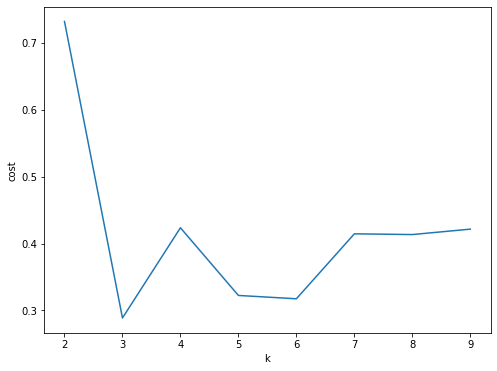

In [75]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

D'après le plot de la silouette, nous constatons que le k-optimal est k=3

Merci pour cette partie de cours qui nous a permis d'acquérir des connaissances et des compétences sur spark